## Load example dataset

In [1]:
import torch
import time
import numpy as np
import pandas as pd
import sklearn as sk
from PIL import Image
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt
%matplotlib inline

#######################################
### PRE-TRAINED MODELS AVAILABLE HERE
## https://pytorch.org/docs/stable/torchvision/models.html
from torchvision import models
#######################################

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
##############################
### Basic Parameter SETTINGS
##############################

# Device
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 233
LEARNING_RATE = 0.01
NUM_EPOCHS = 15
BATCH_SIZE = 256

# Architecture
num_features = 4096
# num_hidden_1 = 128
# num_hidden_2 = 32

Device: cpu


In [3]:
class ASLDataset(Dataset):
    """Custom Dataset for loading ASL images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_names = df['image_name'].values
        self.y = df['class_label'].values
        self.img_dir = img_dir
            
        self.transform = transform
        
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]
    



In [4]:
custom_train_transform = transforms.Compose([transforms.Resize([64, 64]),
                                             transforms.ToTensor(),
                                            transforms.Normalize((0.5,),(0.5,))
                                            ])

custom_test_transform = transforms.Compose([transforms.Resize([64, 64]),
                                            transforms.ToTensor(),
                                           transforms.Normalize((0.5,),(0.5,))
                                           ])

train_dataset = ASLDataset(csv_path='train.csv',
                                    img_dir='asl_alphabet_train/',
                                    transform=custom_train_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True)

valid_dataset = ASLDataset(csv_path='valid.csv',
                                    img_dir='asl_alphabet_train/',
                                    transform=custom_test_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

test_dataset = ASLDataset(csv_path='test.csv',
                                   img_dir='asl_alphabet_train/',
                                   transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: 256
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: 256
(256, 3, 64, 64)
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: 256


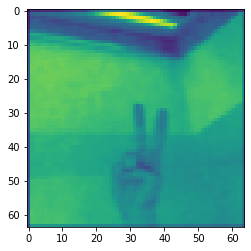

In [5]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', len(labels))  # Tuple
    break
    
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', len(labels))
    plt.imshow(images[198,1,:,:]);
#     plt.savefig('Figures/Example4_randomCrop')
    break
    
for images, labels in test_loader:  
    print(np.asarray(images, dtype=np.uint8).shape)
    
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', len(labels))
    break

## Model

In [6]:
##########################
### MODEL
##########################

class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        ### ENCODER
        
        # 64x64x3 => 64x64x4
        self.conv_1 = torch.nn.Conv2d(in_channels=3,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(64-1) - 64 + 3) / 2 = 1
                                      padding=1)
        # 64x64x4 => 32x32x4
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         # (2(32-1) - 64 + 2) / 2 = 0
                                         padding=0)                                       
        # 32x32x4 => 32x32x8
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(32-1) - 32 + 3) / 2 = 1
                                      padding=1)                 
        # 32x32x8 => 16x16x8                             
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         # (2(16-1) - 32 + 2) / 2 = 0
                                         padding=0)
        
        ### DECODER
                                         
        # 16x16x8 => 32x32x8               
        # Unpool

        # 32x32x8 => 32x32x4
        self.conv_3 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(32-1) - 32 + 3) / 2 = 1
                                      padding=1)
        # 32x32x4 => 64x64x4                            
        # Unpool
        
        # 64x64x4 => 64x64x3
        self.conv_4 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=3,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(64-1) - 64 + 3) / 2 = 1
                                      padding=1)
        
        
    def encoder(self, x):
        x = self.conv_1(x)
        x = F.leaky_relu(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = F.leaky_relu(x)
        x = self.pool_2(x)
        return x
    
    def decoder(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv_3(x)
        x = F.leaky_relu(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv_4(x)
        return torch.tanh(x)
        
    def forward(self, x):
        
        ### ENCODER
        x = self.encoder(x)
        
        ### DECODER
        x = self.decoder(x)
        return x

    
torch.manual_seed(RANDOM_SEED)
model = ConvolutionalAutoencoder()
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train

In [7]:
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = F.mse_loss(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 000/237 | Cost: 0.2365
Epoch: 001/020 | Batch 050/237 | Cost: 0.0350
Epoch: 001/020 | Batch 100/237 | Cost: 0.0211
Epoch: 001/020 | Batch 150/237 | Cost: 0.0171
Epoch: 001/020 | Batch 200/237 | Cost: 0.0151
Time elapsed: 21.87 min
Epoch: 002/020 | Batch 000/237 | Cost: 0.0138
Epoch: 002/020 | Batch 050/237 | Cost: 0.0130
Epoch: 002/020 | Batch 100/237 | Cost: 0.0126
Epoch: 002/020 | Batch 150/237 | Cost: 0.0104
Epoch: 002/020 | Batch 200/237 | Cost: 0.0099
Time elapsed: 26.85 min
Epoch: 003/020 | Batch 000/237 | Cost: 0.0098
Epoch: 003/020 | Batch 050/237 | Cost: 0.0092
Epoch: 003/020 | Batch 100/237 | Cost: 0.0113
Epoch: 003/020 | Batch 150/237 | Cost: 0.0089
Epoch: 003/020 | Batch 200/237 | Cost: 0.0089
Time elapsed: 31.77 min
Epoch: 004/020 | Batch 000/237 | Cost: 0.0084
Epoch: 004/020 | Batch 050/237 | Cost: 0.0083
Epoch: 004/020 | Batch 100/237 | Cost: 0.0091
Epoch: 004/020 | Batch 150/237 | Cost: 0.0080
Epoch: 004/020 | Batch 200/237 | Cost: 0.0077
Time ela

In [8]:
torch.save(model.state_dict(), 'Model/Autoencoder/model_Conv_20epoch_0.01lr.pt')
torch.save(optimizer.state_dict(), 'Model/Autoencoder/optimizer_Conv_20epoch_0.01lr.pt')
# torch.save(scheduler.state_dict(), 'Model/ResNet/scheduler_20epoch_0.0012lr_0.85Decay_every4_0.05dropout.pt')

## Evaluation

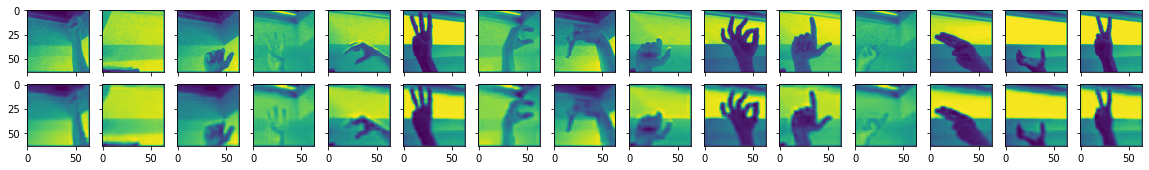

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 64

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i][0].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)))

## Classifier

In [23]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=60921, 
                          shuffle=True)

test_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=17406, 
                          shuffle=False)

In [24]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

X_train = np.array(images.reshape(60921, 64*64*3))
y_train = np.array(labels)


for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

X_test = np.array(images.reshape(17406, 64*64*3))
y_test = np.array(labels)

Image batch dimensions: torch.Size([60921, 3, 64, 64])
Image label dimensions: torch.Size([60921])
Image batch dimensions: torch.Size([17406, 3, 64, 64])
Image label dimensions: torch.Size([17406])


In [26]:
start_time = time.time()

rf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train, y_train)
print(f'Train Accuracy: {rf.score(X_train, y_train)*100}%')
print(f'Test Accuracy: {rf.score(X_test, y_test)*100}%')

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Train Accuracy: 100.0%
Test Accuracy: 99.26462139492129%
Total Training Time: 11.13 min


## Compressed img

In [16]:
X_train_compr = np.ones((60921, 16*16*8))
y_train = np.ones(60921)

start_idx = 0

for idx, (images, labels) in enumerate(train_loader): 
    features = images.to(DEVICE)
    
    with torch.no_grad():
        encoded = model.encoder(features)
    
    X_train_compr[start_idx:start_idx+labels.shape[0]] = encoded.view(-1, 16*16*8).to(torch.device('cpu')).numpy()
    y_train[start_idx:start_idx+labels.shape[0]] = labels
    start_idx += labels.shape[0]

In [18]:
X_test_compr = np.ones((17406, 16*16*8))
y_test = np.ones(17406)

start_idx = 0

for idx, (images, labels) in enumerate(test_loader): 
    features = images.to(DEVICE)
    
    with torch.no_grad():
        encoded = model.encoder(features)
    
    X_test_compr[start_idx:start_idx+labels.shape[0]] = encoded.view(-1, 16*16*8).to(torch.device('cpu')).numpy()
    y_test[start_idx:start_idx+labels.shape[0]] = labels
    start_idx += labels.shape[0]

In [20]:
start_time = time.time()

rf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train_compr, y_train)
print(f'Train Accuracy: {rf.score(X_train_compr, y_train)*100}%')
print(f'Test Accuracy: {rf.score(X_test_compr, y_test)*100}%')

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Train Accuracy: 100.0%
Test Accuracy: 99.63231069746065%
Total Training Time: 10.53 min
